In [1]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde
from scipy.integrate import quad

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('text', usetex=False)

In [2]:
def cfi(state_gen_func, state_gen_args, p, povm, n_copies=1, n_ext=0, dp=1e-5):
    dm = reduce(kron, [state_gen_func(p, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_p = reduce(kron, [state_gen_func(p + dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_m = reduce(kron, [state_gen_func(p - dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    fi = 0
    for op in povm:
        prob = trace(dot(dm, op)).real
        if prob > 0:
            prob_p = trace(dot(dm_p, op)).real
            prob_m = trace(dot(dm_m, op)).real
            der = (prob_p - prob_m)/(2*dp)
            fi += der**2/prob
    return fi

def qfi(state_gen_func, state_gen_args, p, n_copies=1, n_ext=0, dp=1e-2):
    dm = reduce(kron, [state_gen_func(p, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_p = reduce(kron, [state_gen_func(p + dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    fi = 8*(1 - sqrt(fidelity(dm, dm_p))) / dp**2
    return fi

def qfi_central(state_gen_func, state_gen_args, p, n_copies=1, n_ext=0, dp=1e-2):
    dm_p = reduce(kron, [state_gen_func(p + dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_m = reduce(kron, [state_gen_func(p - dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    fi = 8*(1 - sqrt(fidelity(dm_m, dm_p))) / dp**2/4
    return fi

In [3]:
def train_bayes(n_inp, n_layers, a, b, state_gen_func, prior_func, state_gen_args=[], prior_args=[], n_copies=1, n_meas=0, method="BFGS", x0=None, options={}):

    n_tot = n_inp*n_copies
    d = 2**n_tot
        
    if n_meas == 0:
        n_meas = n_tot
    n_pars_est = 2**n_meas
    n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # cry  
    
    d_diff = 0 if n_tot == n_meas else 2**(n_tot - n_meas)
    
    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]

    def fun_int(phi, x_est, U):
        dm = state_gen_func(phi, *state_gen_args)
        dm = reduce(kron, [dm]*n_copies)
        dm_u = U@dm@U.conj().T
        probs = dm_u.diagonal().real
        return np.sum((x_est - phi)**2*probs*prior_func(phi, *prior_args))

    # def fun_int(phi, x_est, U):
    #     dm = state_gen_func(phi, *state_gen_args)
    #     dm = reduce(kron, [dm]*n_copies)
    #     dm_u = U@dm@U.conj().T
    #     H = diag(x_est) - phi*eye(d)
    #     H = H@H
    #     return prior_func(phi, *prior_args)*trace(dm_u@H).real
    
    fvals = []
    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        f = quad(fun_int, a, b, args=(x_est, U))[0]
        fval_cont[0] = f
        return f
        
    def callback(x):
        fvals.append(fval_cont[0])
        print("Iteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, pi)]*n_pars_ans + [(-10, 10)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return fvals, optimization_result

In [4]:
def aux_info(n_inp, pars, a, b, state_gen_func, prior_func, n_layers, labels, state_gen_args=[], prior_args=[], n_copies=1, n_meas=0, dp=1e-5):

    n_tot = n_inp*n_copies
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [U.conj().T@proj@U for proj in projs]
    H = sum([x*proj for x, proj in zip(pars_est, projs_u)])
    H_sq = H@H

    # def func_F(phi):
    #     CFI = cfi(state_gen_func, state_gen_args, phi, projs_u, n_copies=n_copies, n_ext=0, dp=dp)
    #     return CFI*prior_func(phi, *prior_args)
    # def func_I(phi):
    #     prior_der = (prior_func(phi + dp, *prior_args) - prior_func(phi - dp, *prior_args))/(2*dp)
    #     return prior_der**2/prior_func(phi, *prior_args)
    # def func_dphi(phi):
    #     return prior_func(phi, *prior_args)*phi**2
    # def func_QBI(phi):
    #     dm = reduce(kron, [state_gen_func(phi, *state_gen_args)]*n_copies)
    #     return prior_func(phi, *prior_args)*trace(H_sq@dm).real
    
    # int_F = quad(func_F, a, b)[0]
    # int_I = quad(func_I, a, b)[0]
    # CRB = 1/(int_F + int_I)
    # QCRB = quad(func_F, a, b)[0] - quad(func_QBI, a, b)[0]

    dms = []
    dms_der = []
    for phi in labels:
        dm = reduce(kron, [state_gen_func(phi, *state_gen_args)]*n_copies)
        dm_p = reduce(kron, [state_gen_func(phi + dp, *state_gen_args)]*n_copies)
        dm_m = reduce(kron, [state_gen_func(phi - dp, *state_gen_args)]*n_copies)
        dm_der = (dm_p - dm_m)/(2*dp)
        dms.append(dm)
        dms_der.append(dm_der)

    expecs = []
    expecs_der = []
    disps = []
    for j in range(len(labels)): # take a density matrix from the training set
        probs = [trace(dms[j]@proj).real for proj in projs_u]
        probs_der = [trace(dms_der[j]@proj).real for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
    
    return array(expecs), array(expecs_der), array(disps)#, CRB, QCRB#, int_F, int_I, H

# Unitary

In [5]:
def aux_info_uni_1c(pars, n_layers, labels, n_meas=0):

    def uni_dm_1c(p):
        return array([[            1/2, (1/2)*exp(-1j*p)],
                      [(1/2)*exp(1j*p),              1/2]])
    
    def uni_dm_der_1c(p):
        return array([[                 0, -(1/2)*1j*exp(-1j*p)],
                      [(1/2)*1j*exp(1j*p),                    0]])
    
    n_tot = 1
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [U.conj().T@proj@U for proj in projs]
    H = sum([x*proj for x, proj in zip(pars_est, projs_u)])
    H_sq = H@H

    dms = []
    dms_der = []
    for p in labels:
        dms.append(uni_dm_1c(p))
        dms_der.append(uni_dm_der_1c(p))

    expecs = []
    expecs_der = []
    disps = []
    for j in range(len(labels)): # take a density matrix from the training set
        probs = [trace(dms[j]@proj).real for proj in projs_u]
        probs_der = [trace(dms_der[j]@proj).real for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
    
    return array(expecs), array(expecs_der), array(disps)

In [6]:
def aux_info_uni_2c(pars, n_layers, labels, n_meas=0):

    def uni_dm_2c(p):
        return array([[        1, exp(-1j*p), exp(-1j*p), exp(-2j*p)],
                      [exp(1j*p),          1,          1, exp(-1j*p)],
                      [exp(1j*p),          1,          1, exp(-1j*p)],
                      [exp(2j*p),  exp(1j*p), exp(1j*p),          1]]) / 4
    
    def uni_dm_der_2c(p):
        return array([[                 0, -(1/4)*1j*exp(-1j*p), -(1/4)*1j*exp(-1j*p), -(1/2)*1j*exp(-2j*p)],
                      [(1/4)*1j*exp(1j*p),                    0,                    0, -(1/4)*1j*exp(-1j*p)],
                      [(1/4)*1j*exp(1j*p),                    0,                    0, -(1/4)*1j*exp(-1j*p)],
                      [(1/2)*1j*exp(2j*p),   (1/4)*1j*exp(1j*p),   (1/4)*1j*exp(1j*p),                    0]])
    
    n_tot = 2
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [U.conj().T@proj@U for proj in projs]
    H = sum([x*proj for x, proj in zip(pars_est, projs_u)])
    H_sq = H@H

    dms = []
    dms_der = []
    for p in labels:
        dms.append(uni_dm_2c(p))
        dms_der.append(uni_dm_der_2c(p))

    expecs = []
    expecs_der = []
    disps = []
    for j in range(len(labels)): # take a density matrix from the training set
        probs = [trace(dms[j]@proj).real for proj in projs_u]
        probs_der = [trace(dms_der[j]@proj).real for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
    
    return array(expecs), array(expecs_der), array(disps)

In [7]:
def zrot_state_gen(p, dm, tq):
    n_qubits = int(log2(len(dm)))
    dl = 2**tq
    dr = 2**(n_qubits - tq - 1)
    U = reduce(kron, [eye(dl), expm(-1j*p/2*Z), eye(dr)]) # inefficient
    return U@dm@U.conj().T

In [8]:
state_gen_func = zrot_state_gen
dm_inp = (I + X)/2
tq = 0
state_gen_args = [dm_inp, tq]

a = 0 + 0
b = pi - 0
T = 50

eps = 1e-2
labels = linspace(a + eps, b - eps, T)#[1:-1]
dms = [state_gen_func(p, *state_gen_args) for p in labels]

In [9]:
n_inp = int(log2(len(dm_inp)))
method = "BFGS"

In [10]:
n_copies_1 = 1
n_meas_1 = n_inp*n_copies_1
n_layers_1 = 1

prior_func = lambda p: 1/(b - a); prior_args = []
# dphi = 1/sqrt(2)
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies_1 - 1)*n_layers_1 + 2*n_inp*n_copies_1), normal(0., 1, 2**n_meas_1)])

fvals_1, result_1 = train_bayes(n_inp, n_layers_1, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, prior_args=prior_args, n_copies=n_copies_1, n_meas=n_meas_1, method=method, x0=x0, options={})
pars_1 = result_1.x

print("\n", result_1.message)

Iteration: 16 | Function value: 0.41718230
 Optimization terminated successfully.


In [11]:
n_copies_2 = 2
n_meas_2 = n_inp*n_copies_2
n_layers_2 = 2

prior_func = lambda p: 1/(b - a); prior_args = []
# dphi = 1/sqrt(2)
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies_2 - 1)*n_layers_2 + 2*n_inp*n_copies_2), normal(0., 1, 2**n_meas_2)])

fvals_2, result_2 = train_bayes(n_inp, n_layers_2, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, prior_args=prior_args, n_copies=n_copies_2, n_meas=n_meas_2, method=method, x0=x0, options={})
pars_2 = result_2.x


print("\n", result_2.message)

Iteration: 54 | Function value: 0.28097092
 Optimization terminated successfully.


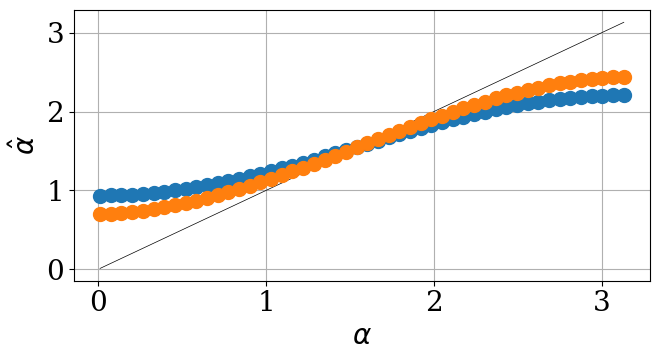

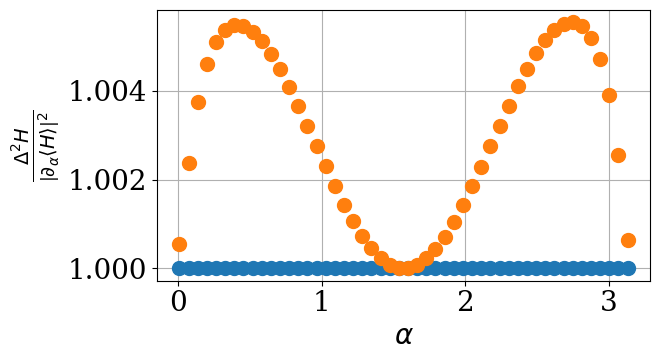

In [12]:
eps = 0.1
dp = 1e-7

expecs_1, expecs_der_1, disps_1 = aux_info(n_inp, pars_1, a+eps, b-eps, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers_1, labels=labels, n_copies=n_copies_1, n_meas=n_meas_1, dp=dp)
expecs_2, expecs_der_2, disps_2 = aux_info(n_inp, pars_2, a+eps, b-eps, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers_2, labels=labels, n_copies=n_copies_2, n_meas=n_meas_2, dp=dp)

expecs_1, expecs_der_1, disps_1 = aux_info_uni_1c(pars_1, n_layers_1, labels)
expecs_2, expecs_der_2, disps_2 = aux_info_uni_2c(pars_2, n_layers_2, labels)

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs_1, s=100, zorder=10)
plt.scatter(labels, expecs_2, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


plt.figure(figsize=(7, 4))
plt.scatter(labels, disps_1/expecs_der_1**2, s=100, zorder=10)
plt.scatter(labels, 2*disps_2/expecs_der_2**2, s=100, zorder=10)
plt.plot(labels, [1]*T, color="tab:green", linewidth=5, label=r"$c\frac{1}{I_q}$", zorder=2)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

# Bell

In [13]:
def bell_state_gen(neg, n_inp, return_dm=False):
    d = 2**n_inp    
    s0n = array([1] + [0]*(d - 1))
    s1n = array([0]*(d - 1) + [1])
    g = sqrt(max(0, 1 - neg**2)) # cope negative sqrt
    v = (sqrt(1 + g)*s0n + sqrt(1 - g)*s1n)/sqrt(2)
    if return_dm == False:
        return v
    else:
        return outer(v, v.conj().T)
    
def bell_state_der_gen(neg, n_inp, return_dm=False):
    d = 2**n_inp
    s0n = array([1] + [0]*(2**n_inp - 1))
    s1n = array([0]*(2**n_inp - 1) + [1])
    g_p = sqrt(1 + neg)
    g_m = sqrt(1 - neg)
    n1 = -N/(2*g_m*g_p*sqrt(1 + g_m*g_p))
    n2 =  N/(2*g_m*g_p*sqrt(1 - g_m*g_p))
    v_der = (n1*s0n + n2*s1n)/sqrt(2)
    if return_dm == False:
        return v_der
    else:
        return outer(v_der, v_der.conj().T)

In [14]:
state_gen_func = bell_state_gen
n_inp = 2
return_dm = True
state_gen_args = [n_inp, return_dm]

a = 0 + 1e-2
b = 1 - 1e-2
T = 11

labels = linspace(a, b, T)#[1:-1]
dms = [state_gen_func(p, *state_gen_args) for p in labels]

In [15]:
method = "BFGS"
n_copies = 1
n_meas = n_inp*n_copies
n_layers = 1

dp = 1e-5

prior_func = lambda p: 1/(b - a); prior_args = []
# dphi = 1/sqrt(2)
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])

fvals, result = train_bayes(n_inp, n_layers, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, prior_args=prior_args, n_copies=n_copies, n_meas=n_meas, method=method, x0=x0, options={})
pars = result.x

print("\n", result.message)

Iteration: 70 | Function value: 0.07034872
 Optimization terminated successfully.


In [16]:
# expecs, expecs_der, disps, CRB, QCRB = aux_info(n_inp, pars, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers, labels=labels, n_copies=n_copies, n_meas=n_meas, dp=dp)
expecs, expecs_der, disps = aux_info(n_inp, pars, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers, labels=labels, n_copies=n_copies, n_meas=n_meas, dp=dp)

n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 1 


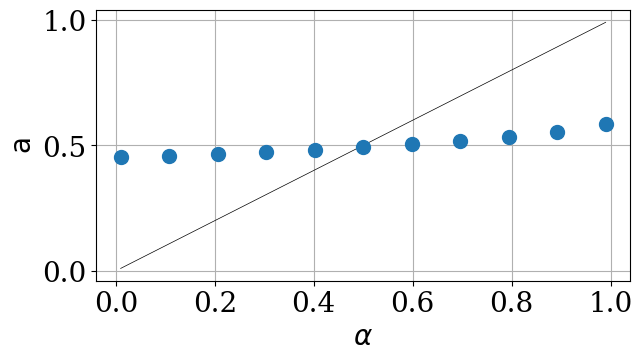

In [17]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

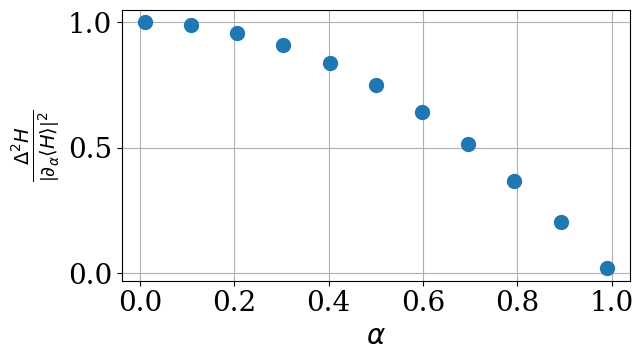

In [18]:
biass = expecs - labels

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps/expecs_der**2, s=100, zorder=10)
# plt.scatter(labels, disps + biass**2, s=100, zorder=10)
# plt.scatter(labels, disps, s=100, zorder=10)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()